## 10th Place Solution for CGIAR Wheat Growth Stage Challenge by CGIAR Platform for Big Data in Agriculture
* By [RsTaK](https://zindi.africa/users/RsTaK)

## My solution is an ensamble of 3 models :
* EfficientNet B2 : Image Size = 256 x 256
* EfficientNet B3 : Image Size = 256 x 256
* EfficientNet B3 : Image Size = 224 x 224 (Different Augmentation)

I'll step by step describe how to run this code in order to get the required solution

Note : I'm using Fastai library to solve this problem

### 1. Get Dataset

Load the dataset provided by [Zindi](https://zindi.africa/competitions/cgiar-wheat-growth-stage-challenge/data) in the competition.

I've saved the Image.zip in my drive so, i'm gonna load it using below cell. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp 'gdrive/My Drive/Images.zip' Images.zip # Provide the path

In [3]:
!unzip -q Images.zip # Unzip it 

I've manually loaded Train.csv and sample_submission.csv

In [4]:
!ls

gdrive	Images	Images.zip  sample_data  SampleSubmission.csv  Train.csv


Now, We have all the required data i.e. "Images" directory, "SampleSubmission.csv" and "Train.csv".

### 2. Import Necessary Libraries

In [5]:
# import Libraries
import random
import os
import gc
import random
random.seed(42)

import pandas as pd
!pip install -q --upgrade fastcore 
!pip install -q --upgrade fastai 
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage 
from fastai.vision.all import *

     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 194kB 9.0MB/s 


### 3. Load dataset

In [6]:
train = pd.read_csv('Train.csv')
train.head(2)

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1


We'll be only using Images with label_quality = 2

In [7]:
train_df = train[train['label_quality']== 2]

print(train_df.shape)
train_df.head(2)

(2856, 3)


,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
7,sYLqmiXV,3,2


### 4. Train the required model

Let's define a small function that we will use in order to get required EfficientNet model

In [8]:
!pip install -q efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

In [9]:
def get_model(pretrained=True, **kwargs):
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(model._fc.in_features, 1)
    return model

### 4.1. EfficientNet b2 : Image Size = 256 x 256

In [13]:
model_name = 'efficientnet-b2'

In [14]:
mean = torch.tensor([[0.05438065, 0.05291743, 0.07920227]])
std = torch.tensor([[0.39414383, 0.33547948, 0.38544176]])

tfms = setup_aug_tfms([Rotate(max_deg=30, p=.5),
            RandomResizedCropGPU(p=0.7, size=256),
            Brightness(max_lighting=.5, p=0.4),
            *aug_transforms(flip_vert=False, p_affine=0.5),
            Normalize.from_stats(mean, std)
            ])

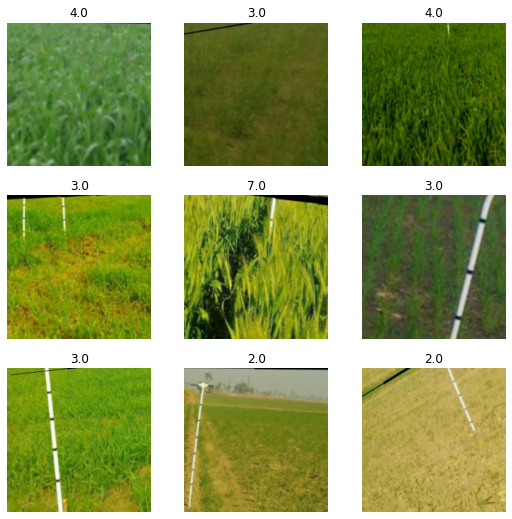

In [15]:
# Data Loader

dls = ImageDataLoaders.from_df(train_df , 
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage', item_tfms=Resize(256), 
                               y_block=RegressionBlock ,
                               batch_tfms = tfms) 
dls.show_batch()

In [16]:
learn = Learner(dls, get_model(), metrics=rmse).to_fp16()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2


In [17]:
callbacks = [
SaveModelCallback(monitor='valid_loss', mode='min',name='bestweights'),
EarlyStoppingCallback(min_delta=1e-5, patience=5),
]
learn.callbacks = callbacks

In [18]:
learn.fine_tune(70)

epoch,train_loss,valid_loss,_rmse,time
0,7.236822,1.755525,1.324962,00:23


epoch,train_loss,valid_loss,_rmse,time
0,0.633145,3.163165,1.778528,00:22
1,0.541078,0.712847,0.844302,00:22
2,0.473089,0.361287,0.601072,00:22
3,0.460726,0.321472,0.566985,00:22
4,0.422553,0.249348,0.499348,00:22
5,0.415456,0.352989,0.594129,00:22
6,0.429977,0.396625,0.629781,00:22
7,0.423843,0.705374,0.839865,00:22
8,0.440322,0.751771,0.867047,00:22
9,0.407460,0.295889,0.543957,00:22


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.75422871709452e-06)

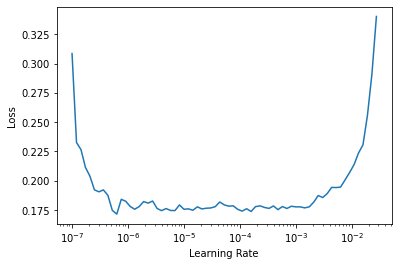

In [19]:
learn.unfreeze()
learn.lr_find()

In [20]:
learn.fit_one_cycle(40, lr_max=slice(10e-06, 10e-07))

epoch,train_loss,valid_loss,_rmse,time
0,0.180356,0.243394,0.493350,00:22
1,0.198819,0.248843,0.498842,00:22
2,0.193800,0.250646,0.500646,00:22
3,0.186320,0.250114,0.500114,00:22
4,0.182784,0.246761,0.496750,00:22
5,0.179286,0.246856,0.496846,00:22
6,0.179312,0.249139,0.499138,00:22
7,0.174563,0.243186,0.493139,00:22
8,0.173464,0.240578,0.490488,00:22
9,0.172445,0.243760,0.493721,00:22


In [21]:
# Prediction

b2_256 = pd.read_csv('SampleSubmission.csv')
tdl = learn.dls.test_dl(b2_256) # Make test dataloader
preds = learn.tta(dl=tdl) # Test Time Augmentation

b2_256['growth_stage'] = preds[0].numpy()

In [22]:
b2_256.head(5)

,UID,growth_stage
0,F3LbWkZq,5.224121
1,6P4wLVzI,3.832520
2,Tn6HIrdS,2.682129
3,EYM5R1TK,4.044800
4,fkcevlA0,4.902588


In [23]:
b2_256.to_csv("b2-256.csv", index=False) # Use this to export csv file

### 4.2. EfficientNet b3 : Image Size = 256 x 256

In [24]:
model_name = 'efficientnet-b3'

In [25]:
mean = torch.tensor([[0.05438065, 0.05291743, 0.07920227]])
std = torch.tensor([[0.39414383, 0.33547948, 0.38544176]])

# Image Augmentation
tfms = setup_aug_tfms([Rotate(max_deg=30, p=.5),
            RandomResizedCropGPU(p=0.7, size=256),
            Brightness(max_lighting=.5, p=0.4),
            *aug_transforms(flip_vert=False, p_affine=0.5),
            Normalize.from_stats(mean, std)
            ])

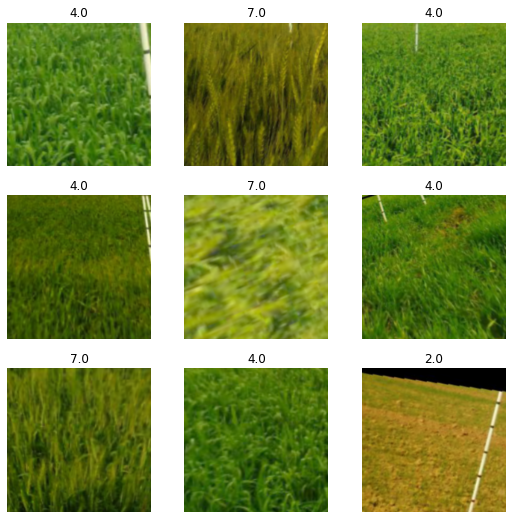

In [26]:
# Data Loader

dls = ImageDataLoaders.from_df(train_df , 
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage', item_tfms=Resize(256), 
                               y_block=RegressionBlock ,
                               batch_tfms = tfms) 
dls.show_batch()

In [27]:
learn = Learner(dls, get_model(), metrics=rmse).to_fp16()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


In [28]:
callbacks = [
SaveModelCallback(monitor='valid_loss', mode='min',name='bestweights'),
EarlyStoppingCallback(min_delta=1e-5, patience=5),
]
learn.callbacks = callbacks

In [29]:
learn.fine_tune(70)

epoch,train_loss,valid_loss,_rmse,time
0,6.888113,0.955882,0.977692,00:28


epoch,train_loss,valid_loss,_rmse,time
0,0.560024,2.263804,1.504594,00:27
1,0.493258,0.498702,0.706188,00:27
2,0.464194,0.349129,0.590872,00:26
3,0.444606,0.295502,0.543601,00:27
4,0.415736,0.283865,0.532790,00:27
5,0.425873,0.365138,0.604266,00:27
6,0.410237,0.447049,0.668617,00:26
7,0.374313,0.318073,0.563980,00:27
8,0.375404,0.286639,0.535386,00:27
9,0.378030,1.651214,1.284996,00:27


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

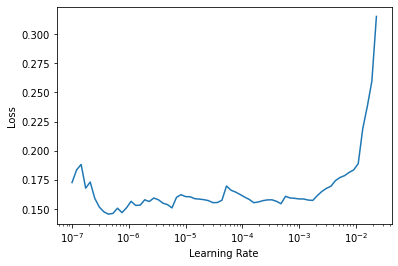

In [30]:
learn.unfreeze()
learn.lr_find()

In [31]:
learn.fit_one_cycle(40, lr_max=slice(10e-08, 10e-5))

epoch,train_loss,valid_loss,_rmse,time
0,0.189104,0.225889,0.475278,00:27
1,0.193816,0.231612,0.481261,00:27
2,0.179300,0.230518,0.480123,00:27
3,0.167207,0.221550,0.470690,00:27
4,0.172043,0.232956,0.482655,00:27
5,0.178733,0.227407,0.476872,00:27
6,0.185875,0.233607,0.483329,00:27
7,0.174516,0.235895,0.485690,00:27
8,0.168884,0.240707,0.490619,00:27
9,0.190283,0.251235,0.501233,00:27


In [32]:
# Prediction

b3_256 = pd.read_csv('SampleSubmission.csv')
tdl = learn.dls.test_dl(b3_256) # Make test dataloader
preds = learn.tta(dl=tdl) # Test Time Augmentation

b3_256['growth_stage'] = preds[0].numpy()

In [33]:
b3_256.head()

,UID,growth_stage
0,F3LbWkZq,4.468506
1,6P4wLVzI,3.879883
2,Tn6HIrdS,2.959106
3,EYM5R1TK,4.206787
4,fkcevlA0,4.627441


In [34]:
b3_256.to_csv("b3-256.csv", index=False) # Use this to export csv file

### 4.3. EfficientNet b3 : Image Size = 224 x 224

In [35]:
model_name = 'efficientnet-b3'

In [36]:
mean = torch.tensor([[0.05438065, 0.05291743, 0.07920227]])
std = torch.tensor([[0.39414383, 0.33547948, 0.38544176]])

# Image Augmentation
tfms = setup_aug_tfms([Rotate(max_deg=15, p=1.),
            RandomResizedCrop(p=1., size=224),
            Brightness(max_lighting=1.0, p=0.4),
            #CropPad(size=256),
            #Zoom(max_zoom=1.0, p=0.2,
            Warp(magnitude=0.2, p=0.2),
            Normalize.from_stats(mean, std)
            ])

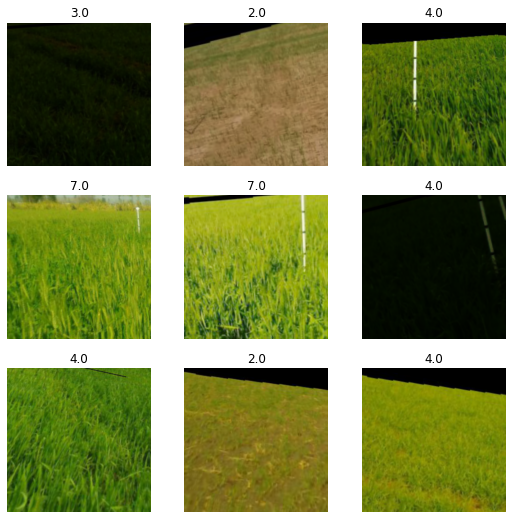

In [37]:
# Data Loader

dls = ImageDataLoaders.from_df(train_df , 
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage', item_tfms=Resize(256), 
                               y_block=RegressionBlock ,
                               batch_tfms = tfms) 
dls.show_batch()

In [40]:
learn = Learner(dls, get_model(), metrics=rmse).to_fp16()

Loaded pretrained weights for efficientnet-b3


In [41]:
learn.fine_tune(70)

epoch,train_loss,valid_loss,_rmse,time
0,6.746317,4.684720,2.164421,00:26


epoch,train_loss,valid_loss,_rmse,time
0,0.557870,0.434221,0.658954,00:27
1,0.462804,0.419412,0.647621,00:27
2,0.411318,0.486846,0.697743,00:27
3,0.380208,0.292658,0.540978,00:27
4,0.355368,0.263413,0.513237,00:27
5,0.358009,0.277575,0.526854,00:26
6,0.352621,0.377469,0.614385,00:27
7,0.344295,0.363688,0.603065,00:26
8,0.334007,0.410899,0.641014,00:26
9,0.348057,0.466114,0.682725,00:27


SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=6.309573450380412e-07)

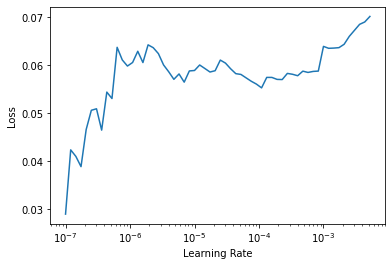

In [42]:
learn.unfreeze()
learn.lr_find()

In [43]:
learn.fit_one_cycle(40, lr_max=slice(10e-7, 10e-5))

epoch,train_loss,valid_loss,_rmse,time
0,0.051913,0.208111,0.456192,00:26
1,0.051668,0.208327,0.456428,00:27
2,0.054206,0.206202,0.454095,00:26
3,0.060130,0.208285,0.456382,00:26
4,0.055858,0.207119,0.455103,00:26
5,0.051907,0.206717,0.454662,00:26
6,0.053235,0.203412,0.451012,00:26
7,0.052661,0.210346,0.458635,00:26
8,0.057050,0.220389,0.469456,00:26
9,0.054993,0.215534,0.464257,00:26


In [44]:
# Prediction

b3_256_dif = pd.read_csv('SampleSubmission.csv')
tdl = learn.dls.test_dl(b3_256_dif) # Make test dataloader
preds = learn.tta(dl=tdl) # Test Time Augmentation

b3_256_dif['growth_stage'] = preds[0].numpy()

In [45]:
b3_256_dif

,UID,growth_stage
0,F3LbWkZq,4.931396
1,6P4wLVzI,3.898438
2,Tn6HIrdS,2.973022
3,EYM5R1TK,4.004883
4,fkcevlA0,4.753174
...,...,...
3553,H9UastWl,4.011230
3554,lXiDhZGC,5.145264
3555,F0VDr9Zc,4.041382
3556,3Fl5H12A,1.970276


In [46]:
b3_256_dif.to_csv("b3-256-dff.csv", index=False) # Use this to export csv file

### 5. Ensemble

In [49]:
final=b3_256_dif.copy()

final.growth_stage=0.6*b3_256_dif.growth_stage+0.3*b3_256.growth_stage+0.1*b2_256.growth_stage

final.to_csv("final_sub.csv", index=False)